# (E5)Realization_of_Spectogram_calssification's_model_InYu
  
1. 데이터 처리와 분류  
   1) 라벨 데이터 처리하기  
   2) sklearn의 train_test_split함수를 이용하여 train, test 분리    
      
2. 학습을 위한 하이퍼파라미터 설정    
  
3. 데이터셋 구성  
   1) tf.data.Dataset을 이용  
   2) from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용   
   3) map과 batch를 이용한 데이터 전처리  
  
4. 2차원 Spectrogram 데이터를 처리하는 모델 구성  
      
5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
    loss, accuracy를 그래프로 표현  
      
6. Test dataset을 이용해서 모델의 성능을 평가  
   1) 저장한 weight 불러오기  
      모델의 예측값과 정답값이 얼마나 일치하는지 확인  

## 1. 데이터 처리와 분류
### 1) 라벨 데이터 처리하기

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [3]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path) # np.load()함수로 npz파일 열어 배열로 불러온다.

print(speech_data) 

In [4]:
# npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장
# 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있습니다.
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
print('speech_data타입:',type(speech_data))
print('speech_data["wav_vals"]타입:',type(speech_data["wav_vals"]))
print('speech_data["label_vals"]타입:',type(speech_data["label_vals"]))

speech_data타입: <class 'numpy.lib.npyio.NpzFile'>
speech_data["wav_vals"]타입: <class 'numpy.ndarray'>
speech_data["label_vals"]타입: <class 'numpy.ndarray'>


```# 많은 단어의 반복 확인하기
for i in range(120, 123) : 
    print(speech_data["wav_vals"][i])
    print(speech_data["label_vals"][i])
```
실행하면 아래와 같이 나온다.  
\[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.8508673e-05
 -1.6771010e-05 -4.5352524e-05]  
\['down']  
\[ 1.0690438e-04  1.0059651e-04  4.4463042e-05 ... -1.7473207e-06
  6.1626197e-05  2.3100653e-04]  
\['down']  
\[-0.00024025 -0.00061578 -0.00053798 ... -0.00056475 -0.00047532
 -0.00034912]  
\['down']  
  
>speech_data 안에는 총 12개의 단어가 들어있는데, 샘플 개수는 50620이다.  
그 이유는 위와 같이 단어들이 반복되어 있음을 알 수 있다.

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go','unknown','silence'  ]

label_value = target_list
print('LABEL : ', label_value) # 밑 코드에서 label_value를 리스트를 딕셔너리로 바꿈

new_label_value = dict()
for i, l in enumerate(label_value): # i 라벨목록값, l 인덱스값
    new_label_value[l] = i
label_value = new_label_value
print('Indexed LABEL : ', new_label_value)

reverse_dict = {v: k for k, v in new_label_value.items()} # 위의 Dict에서 key-value 뒤집기
print('Decoded LABEL:', reverse_dict)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}
Decoded LABEL: {0: 'yes', 1: 'no', 2: 'up', 3: 'down', 4: 'left', 5: 'right', 6: 'on', 7: 'off', 8: 'stop', 9: 'go', 10: 'unknown', 11: 'silence'}


### 2) speech_data\["label_vals"] -> Indexed LABEL 로 배열(numpy.ndarray) 생성

In [7]:
temp = []
for v in speech_data["label_vals"]: 
    #print(v[0])
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(type(label_data))
print(label_data)
print('--------------------------')
# numpy.ndarray 확인하기
print(speech_data["label_vals"][0])
print(label_data[0])

<class 'numpy.ndarray'>
[ 3  3  3 ... 11 11 11]
--------------------------
['down']
3


## \*1차원인 wav 음성 데이터를 Spectrogram으로 변환\*

In [8]:
import librosa

# 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

>- np.abs : 절대값을 구하는 함수
>- librosa.stft : 짧은 겹치는 창에 대해 이산 푸리에 변환 (DFT)을 계산하여 시간-주파수 영역의 신호를 나타냅니다.

In [9]:
tmp = []
for wav in speech_data["wav_vals"] : # speech_data 할 일 다 함
    spec = wav2spec(wav) 
    tmp.append(spec)

In [10]:
spec_data = np.array(tmp) # 2차원으로 변환한 data 변수 지정


print(speech_data["wav_vals"].shape)
print(spec_data.shape)

(50620, 8000)
(50620, 130, 126)


### 3)sklearn의 train_test_split함수를 이용하여 train, test 분리

In [11]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(spec_data, # spec_data 할 일 다 함
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

print(type(train_spec))
print(train_spec.shape)
print(test_spec.shape)

<class 'numpy.ndarray'>
(45558, 130, 126)
(5062, 130, 126)


In [12]:
# del을 이용해서 speech_data 변수를 지워
del speech_data
del spec_data

### \*Spectrogram 시각화로 데이터가 잘 들어왔는지 확인\*

In [13]:
import random
# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(train_spec))

data = train_spec[rand]
print('2차원 data shape:', data.shape)

# rand숫자에 대한 라벨 
print("0 ~ 45557 중  : ", rand) 
print(rand,'의 label :', train_label[rand])

i = train_label[rand]
print(rand, 'label의 target :', reverse_dict[i])

2차원 data shape: (130, 126)
0 ~ 45557 중  :  8853
8853 의 label : 3
8853 label의 target : down


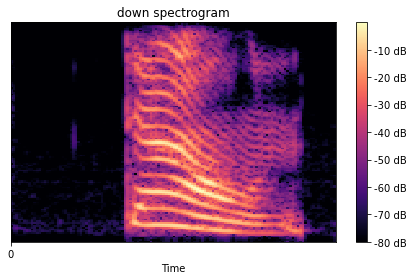

In [14]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(data, ref=np.max), x_axis='time')
plt.title(reverse_dict[i] + ' ' + 'spectrogram') # 해당 스펙토그램 target 같이 쓰기
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 2. 하이퍼파라미터 세팅
### 1) checkpoint 

In [15]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec' 

# 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.
print(checkpoint)

/home/aiffel-dj35/aiffel/speech_recognition/models/spec


## 3. 데이터셋 구성

In [16]:
# 원핫인코딩 
# 텍스트를 [0,0,0,0,0,1,0,0,0,0,0,0] 꼴로 변경하기 위한 함수
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12) # 12개인 이유는 12단어 이기때문에
    return spec, label

### 1) tf.data.Dataset을 이용  &
### 2) from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용 &
### 3) map과 batch를 이용한 데이터 전처리

In [17]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


In [18]:
print(type(test_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성  

In [19]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126)) #(130,126)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model01_spec = tf.keras.Model(input_tensor, output_tensor)

model01_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model01_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [21]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model01_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [22]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [23]:
history_spec01 = model01_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1421/1423 [============================>.] - ETA: 0s - loss: 1.3759 - accuracy: 0.5245
Epoch 00001: val_loss improved from inf to 0.89285, saving model to /home/aiffel-dj35/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 11s 8ms/step - loss: 1.3751 - accuracy: 0.5248 - val_loss: 0.8928 - val_accuracy: 0.7035
Epoch 2/10
1417/1423 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.7846
Epoch 00002: val_loss improved from 0.89285 to 0.52282, saving model to /home/aiffel-dj35/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 11s 7ms/step - loss: 0.6524 - accuracy: 0.7847 - val_loss: 0.5228 - val_accuracy: 0.8313
Epoch 3/10
1419/1423 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8531
Epoch 00003: val_loss improved from 0.52282 to 0.43521, saving model to /home/aiffel-dj35/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 11s 8ms/step 

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

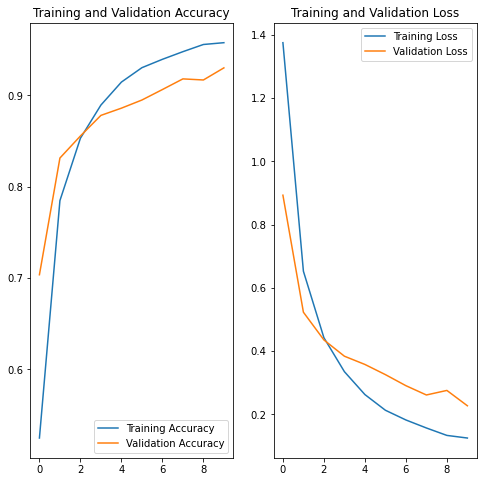

In [24]:
import matplotlib.pyplot as plt

acc = history_spec01.history['accuracy']
val_acc = history_spec01.history['val_accuracy']

loss=history_spec01.history['loss']
val_loss=history_spec01.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Test dataset을 이용해서 모델의 성능을 평가

### 1) 저장한 weight 불러오기

In [25]:
model01_spec.load_weights(checkpoint)

In [26]:
# evaluate
results = model01_spec.evaluate(test_dataset)

159/159 [==============================] - 20s 128ms/step - loss: 0.2268 - accuracy: 0.9301


In [27]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.227
accuracy value: 93.0067%


In [28]:
del model01_spec

## +Skip-Connection model

In [29]:
sr= 8000
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model01_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model01_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [30]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model01_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [31]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [ ]:
#30분 내외 소요 => 커널이 터졌다.
model01_spec_skip = model01_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

In [ ]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [ ]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

## 루브릭 평가
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다. 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.  
> sampling된 data를 FFT(시간영역의 신호를 주파수 영역으로 변환시키는 알고리즘)을 사용해서 변환한다.  
random으로 고른 data에 해당 targat과 함께 spectogram을 그렸다.  
split을 이용해서 전체의 1/10만 test data로 구성했다.
  

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다. 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
> 1차원 모델로 진행했고 메모리를 많이 써서 중간에 많이 연결이 끊어졌지만, batch size를 조정하면서 정상 작동하게 되었다. complie -> fit -> evaluation 까지 모두 진행하였다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다. evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
> 1차원 모델의 acc는 92.01% 정도로 높게 나왔다.
***
## 회고
완벽히 이해하지는 못했지만, 음성 데이터를 1차원과 2차원에서도 그대로 Conv1D로 쓸 수 있는 점을 처음 알게 되었다. 터널이 끊겼는데, 슬랙에서 도움을 받아서 GPU를 관리하는 방법으로 해결했다. 코드가 올바르다고 모두 진행할 수 있는 건 아니다. 주어진 환경(gpu 용량)에서 실행 될 수 있도록 코드 또는 필요하지 않은 인자들을 적절한 타이밍에 delete 할 수 있다. 온라인 수업이지만 집단지성의 힘을 이렇게 종종 마주한다. 다음 자연어에서는 자세한 설명이 있다면 발전된 모습으로 해결할 수 있을 것이다. 

***
## 더 탐구
+ 나열하기에는 많은 speech_data으로 target_list를 알아낼 수 있을까?
+ numpy 복습
+ del에 대한 복습
+ skip-connectiondp의 이해와 실행